In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
def get_trasnform_data():
    coordinates = pd.read_csv('readonly/latlons.csv')
    coordinates.address = coordinates.address.str.lower().str.replace('[^\w]', '')
    coordinates = coordinates.drop_duplicates()

    addresses = pd.read_csv('readonly/addresses.csv')
    addresses.address = addresses.address.str.lower().str.replace('[^\w]', '')
    addresses = addresses.merge(coordinates, how='left', left_on='address', right_on='address')

    raw_data = pd.read_csv('readonly/train.csv', encoding='windows-1250')
    raw_data = raw_data[~raw_data.compliance.isna()]
    print('Raw data n rows: {}'.format(len(raw_data.index)))

    #feature processing
    df = raw_data.merge(addresses, how='left', left_on='ticket_id', right_on='ticket_id', validate='one_to_many')
    print('df n rows: {}'.format(len(df.index)))
    df['another_city'] = df.city != 'Detroit'
    df['another_state'] = df.state != 'MI'
    df['hearing_issue_date_diff'] = (pd.to_datetime(df.ticket_issued_date) - pd.to_datetime(df.hearing_date)).dt.days
    transformed_vars = ['city', 'state', 'address', 'ticket_issued_date', 'hearing_date', 'balance_due']
    leakage_var = ['payment_amount', 'payment_date', 'payment_status', 'payment_status', 'collection_status',
                    'compliance_detail']
    noise_var = ['ticket_id', 'violator_name', 'violation_street_number', 'violation_zip_code',
                'violation_street_name', 'mailing_address_str_number', 'mailing_address_str_name', 'zip_code',
                'violation_description']
    bad_var = [
            'clean_up_cost', #all rows = 0
            'non_us_str_code', #high na rate
            'grafitti_status' #high na rate
        ]
    columns_to_drop = leakage_var + noise_var + transformed_vars
    df = df.drop(columns_to_drop, axis='columns')
    #y_train = pd.get_dummies(df.compliance)
    #X_train = pd.get_dummies(df.drop('compliance', axis='columns'))
    return (raw_data, df)#, X_train, y_train)
raw_data, df = get_trasnform_data()

C:\Users\CarlosLimaSantoro\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (11,12,31) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
Raw data n rows: 159880
df n rows: 159880


In [3]:
raw_data.clean_up_cost.unique()

array([0.])

In [4]:
(raw_data.isna().sum()*100 / len(raw_data.index))

ticket_id                       0.000000
agency_name                     0.000000
inspector_name                  0.000000
violator_name                   0.016262
violation_street_number         0.000000
violation_street_name           0.000000
violation_zip_code            100.000000
mailing_address_str_number      1.599950
mailing_address_str_name        0.001876
city                            0.000000
state                           0.052539
zip_code                        0.000625
non_us_str_code                99.998124
country                         0.000000
ticket_issued_date              0.000000
hearing_date                    0.141981
violation_code                  0.000000
violation_description           0.000000
disposition                     0.000000
fine_amount                     0.000000
admin_fee                       0.000000
state_fee                       0.000000
late_fee                        0.000000
discount_amount                 0.000000
clean_up_cost   

C:\Users\CarlosLimaSantoro\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


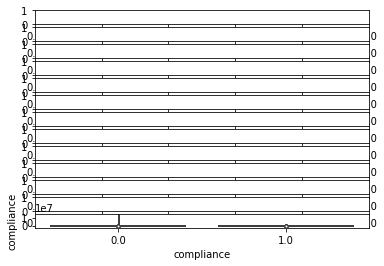

In [52]:
float_vars = raw_data.columns[raw_data.dtypes == 'float64']
figure, ax = plt.subplots(len(float_vars), 1)

for (i, axe), var in zip(enumerate(ax), float_vars):
    ax[i] = sns.violinplot(x='compliance', y=var, data=raw_data)
figure.show()